<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/CT_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Edited: Sama
# Spleen 3D CT Regression with MONAI



## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib


from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 2.8 MB/s eta 0:00:00


## Set dataset path

In [2]:
from google.colab import drive
drive.mount('/content/drive')
root_dir = '/content/drive/My Drive/MONAI_data'
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"
os.makedirs(root_dir, exist_ok=True)
compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

train_images = sorted(glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
# Create data dictionaries
data_dicts = [{"image": img, "target": img} for img in train_images]
# making  smaller input to save time for practing stage:
train_files, val_files = data_dicts[-1:], data_dicts[-1:]

set_determinism(seed=0)

Mounted at /content/drive


## Define CacheDataset and DataLoader

In [3]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(
            keys=["image", "target"],
            a_min=-1024,
            a_max=2048,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "target"],
            label_key="target",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),

    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        ScaleIntensityRanged(
            keys=["image", "target"],
            a_min=-1024,
            a_max=2048,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "target"], source_key="image"),
        Orientationd(keys=["image", "target"], axcodes="RAS"),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

train_ds = CacheDataset(data=train_files, transform=train_transforms)
train_loader = DataLoader(train_ds, batch_size=8, shuffle=True, num_workers=2)

val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)


/usr/local/lib/python3.10/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)
Loading dataset: 100%|██████████| 1/1 [00:04<00:00,  4.40s/it]


In [4]:
# Load a few sample images from the train_loader and print their sizes
for i, batch_data in enumerate(train_loader):
    images = batch_data["image"]
    print(f"Batch {i} image size: {images.shape}")
    if i == 2:  # Adjust this to inspect more or fewer batches
        break


Batch 0 image size: torch.Size([4, 1, 96, 96, 96])


image shape: torch.Size([255, 255, 101]), target shape: torch.Size([255, 255, 101])


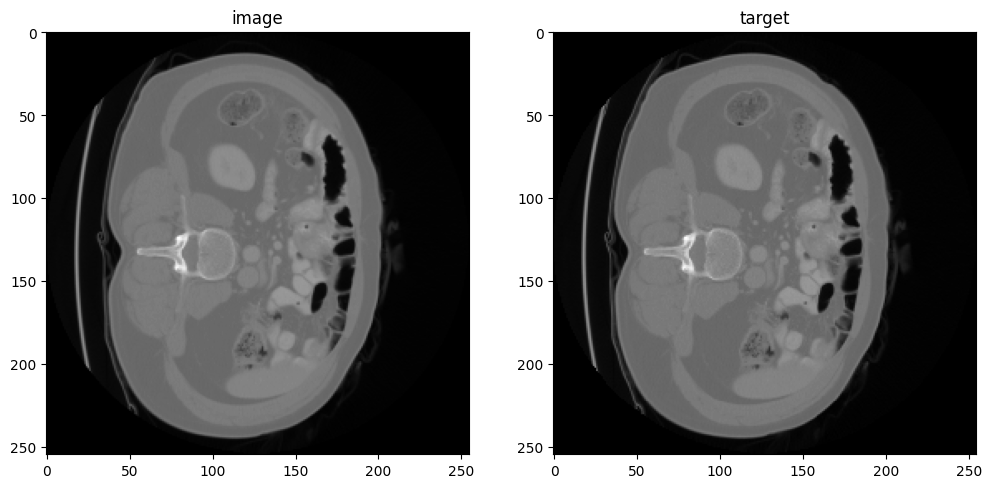

In [5]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 15
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, n], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, :, n], cmap= "gray")
plt.show()

## Create Model, Loss, Optimizer

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-6)


## Execute a typical PyTorch training process

In [7]:
max_epochs = 20
val_interval = 2
best_metric = float('inf')  # Initialize with infinity, since lower MSE is better
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
roi_size = (8, 8, 8)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0

    for batch_data in train_loader:
        step += 1
        inputs, targets = (
            batch_data["image"].to(device),
            batch_data["target"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(f"{step}/{len(train_ds) // train_loader.batch_size}, train_loss: {loss.item():.4f}")

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_targets = (
                    val_data["image"].to(device),
                    val_data["target"].to(device),
                )

                val_outputs = sliding_window_inference(val_inputs, roi_size,
                                            sw_batch_size, model, overlap=0.50)
                # Compute MSE for current iteration
                val_loss += loss_function(val_outputs, val_targets).item()

            val_loss /= len(val_loader)
            metric_values.append(val_loss)

            print(f"current epoch: {epoch + 1} current val loss: {val_loss:.4f}")

            # Save the model state for the current epoch
            torch.save(model.state_dict(), os.path.join(root_dir, f"epoch_{epoch + 1}_model.pth"))

            # Check if the current model has a better validation loss
            if val_loss < best_metric:
                best_metric = val_loss
                best_metric_epoch = epoch + 1
                # Save the best model state
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")

# Save the model after the last epoch
torch.save(model.state_dict(), os.path.join(root_dir, "last_epoch_model.pth"))




----------
epoch 1/20
1/0, train_loss: 0.4956
epoch 1 average loss: 0.4956
----------
epoch 2/20
1/0, train_loss: 0.4755
epoch 2 average loss: 0.4755
current epoch: 2 current val loss: 0.0282
saved new best metric model
----------
epoch 3/20
1/0, train_loss: 0.4910
epoch 3 average loss: 0.4910
----------
epoch 4/20
1/0, train_loss: 0.4795
epoch 4 average loss: 0.4795
current epoch: 4 current val loss: 0.0286
----------
epoch 5/20
1/0, train_loss: 0.4942
epoch 5 average loss: 0.4942
----------
epoch 6/20
1/0, train_loss: 0.4490
epoch 6 average loss: 0.4490
current epoch: 6 current val loss: 0.0292
----------
epoch 7/20
1/0, train_loss: 0.4947
epoch 7 average loss: 0.4947
----------
epoch 8/20
1/0, train_loss: 0.5142
epoch 8 average loss: 0.5142
current epoch: 8 current val loss: 0.0305
----------
epoch 9/20
1/0, train_loss: 0.4922
epoch 9 average loss: 0.4922
----------
epoch 10/20
1/0, train_loss: 0.4659
epoch 10 average loss: 0.4659
current epoch: 10 current val loss: 0.0324
---------

## Plot the loss and metric

train completed, best_metric: 0.0282 at epoch: 2


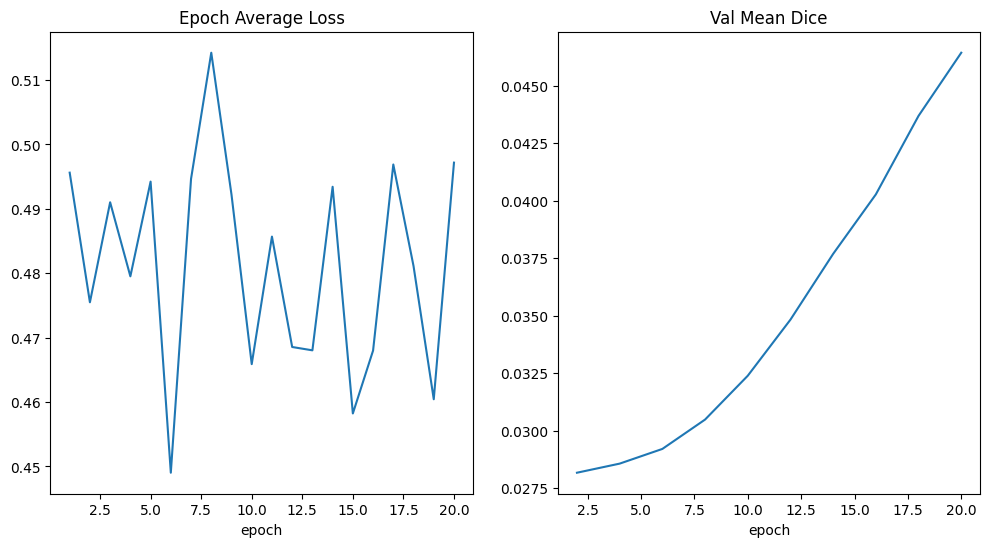

In [8]:
print(f"train completed, best_metric: {best_metric:.4f} " f"at epoch: {best_metric_epoch}")
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

100%|██████████| 90334/90334 [13:18<00:00, 113.13it/s]


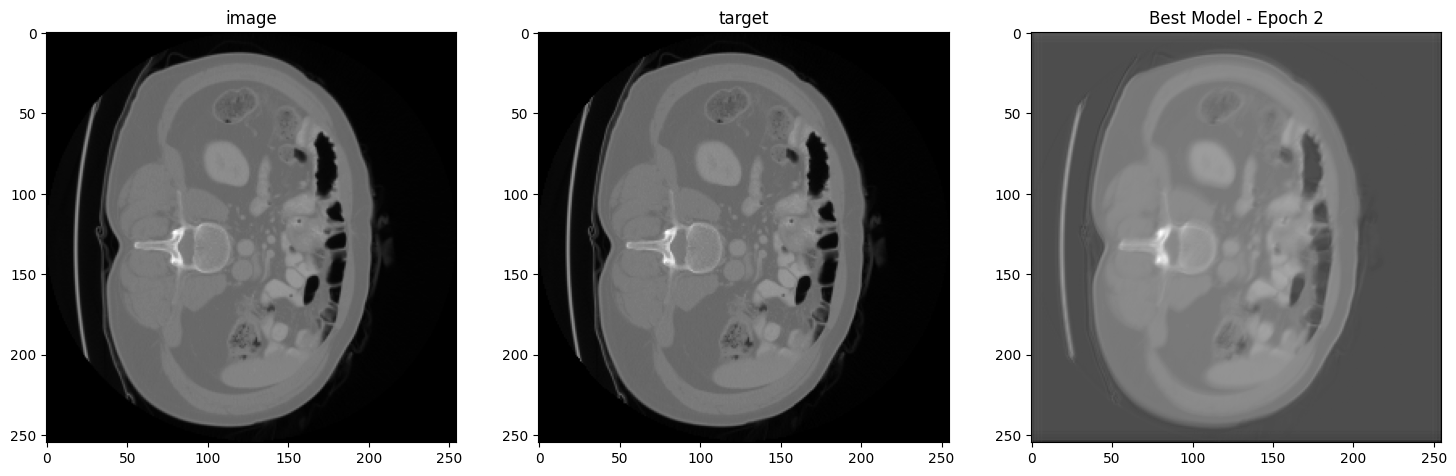

In [9]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                                           sw_batch_size, model, progress=True, overlap=0.90) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"image")
    plt.imshow(val_data["image"][0, 0, :, :, n], cmap="gray")

    plt.subplot(1, 3, 2)
    plt.title(f"target")
    plt.imshow(val_data["target"][0, 0, :, :, n], cmap="gray")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, :, n]
    plt.imshow(output_slice, cmap="gray")
    plt.show()


    # Load the best model state for visualization
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        # Visualization code for the best model state...
        n = 15
        visualize_results(val_data, model, n, f"Best Model - Epoch {best_metric_epoch}")
        if i == 0:
            break
# # Load the last model state for visualization
# model.load_state_dict(torch.load(os.path.join(root_dir, "last_epoch_model.pth")))
# model.eval()
# with torch.no_grad():
#     for i, val_data in enumerate(val_loader):
#         # Visualization code for the last model state...
#         n = 15
#         visualize_results(val_data, model, n, f"Last Epoch - Epoch {max_epochs}")


#         if i == 0:
#             break

---------------------

In [10]:
# drive.mount('/content/gdrive')
# model_path = "/content/drive/My Drive/MONAI_data/best_metric_model.pth"

# model.load_state_dict(torch.load(model_path))
# best_metric_epoch = 14
# roi_size = (80, 80, 80)
# sw_batch_size = 16 # Increase the overlap by using a higher sw_batch_size